In [1]:
import torch
import matplotlib.pyplot as plt
from dataset import TextDataset
from torch.utils.data import DataLoader
from model import WordSubstitutionDetector
from model_trainer import ModelTrainer

In [2]:
data_dir = './data'
weights_dir = './weights'
device = 'cuda'

In [3]:
train_dataset = TextDataset(base_path=data_dir,
                            split_name='train_small',
                            max_len=None)

train_loader = DataLoader(train_dataset,
                      batch_size=1024,
                      shuffle=False,
                      num_workers=6,
                      pin_memory=True,
                      drop_last=False,
                      timeout=0,
                      worker_init_fn=None)

vocab = train_dataset.get_vocab()


val_dataset = TextDataset(base_path=data_dir,
                          split_name='val',
                          max_len=None,
                          vocab=vocab)

val_loader = DataLoader(val_dataset,
                      batch_size=1024,
                      shuffle=False,
                      num_workers=6,
                      pin_memory=True,
                      drop_last=False,
                      timeout=0,
                      worker_init_fn=None)

[DATASET] Maximum line length: 1333
[DATASET] Vocabulary size: 19179
[DATASET] Maximum line length: 818
[DATASET] Vocabulary size: 19179


In [4]:
print(len(vocab))

17275


In [22]:
for batch in d_loader:
    batch_lines, batch_labels, line_lenghts = batch
    print(batch_lines[10])
    break

tensor([149, 150, 151, 152,  13,  12,   8,   0,   0, 155,   0,   0,   0,  33,
        159, 160, 161,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
          1,   1])


In [4]:
model = WordSubstitutionDetector(len(vocab) + 2, embedding_dim=100, hidden_dim=200).to(device)

num_trainable_param = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('{} trainable parameters'.format(num_trainable_param))

2159901 trainable parameters


In [5]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

In [6]:
trainer = ModelTrainer(model, criterion, optimizer, device)

In [7]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 30)

Epoch 0/29
[30/ 196] loss: 0.670
[60/ 196] loss: 0.656
[90/ 196] loss: 0.641
[120/ 196] loss: 0.628
[150/ 196] loss: 0.614
[180/ 196] loss: 0.602
Epoch 0 train loss: 0.6385
Epoch 0 val loss: 0.5905
--------------------------------------------------
Epoch 1/29
[30/ 196] loss: 0.582
[60/ 196] loss: 0.570
[90/ 196] loss: 0.558
[120/ 196] loss: 0.546
[150/ 196] loss: 0.535
[180/ 196] loss: 0.524
Epoch 1 train loss: 0.5551
Epoch 1 val loss: 0.5145
--------------------------------------------------
Epoch 2/29
[30/ 196] loss: 0.507
[60/ 196] loss: 0.497
[90/ 196] loss: 0.486
[120/ 196] loss: 0.476
[150/ 196] loss: 0.466
[180/ 196] loss: 0.457
Epoch 2 train loss: 0.4838
Epoch 2 val loss: 0.4494
--------------------------------------------------
Epoch 3/29
[30/ 196] loss: 0.442
[60/ 196] loss: 0.434
[90/ 196] loss: 0.425
[120/ 196] loss: 0.416
[150/ 196] loss: 0.408
[180/ 196] loss: 0.400
Epoch 3 train loss: 0.4229
Epoch 3 val loss: 0.3939
--------------------------------------------------
Epoc

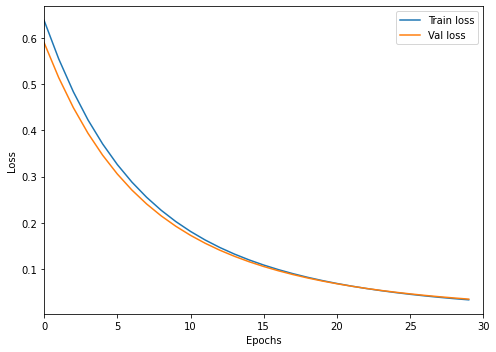

In [8]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))

In [10]:
train_loss, val_loss = trainer.fit(train_loader, val_loader, 0, 30)

Epoch 0/29
[30/ 196] loss: 0.102
[60/ 196] loss: 0.096
[90/ 196] loss: 0.082
[120/ 196] loss: 0.074
[150/ 196] loss: 0.072
[180/ 196] loss: 0.076
Epoch 0 train loss: 0.1125
Epoch 0 val loss: 0.0723
--------------------------------------------------
Epoch 1/29
[30/ 196] loss: 0.070
[60/ 196] loss: 0.071
[90/ 196] loss: 0.069
[120/ 196] loss: 0.070
[150/ 196] loss: 0.069
[180/ 196] loss: 0.074
Epoch 1 train loss: 0.0709
Epoch 1 val loss: 0.0704
--------------------------------------------------
Epoch 2/29
[30/ 196] loss: 0.068
[60/ 196] loss: 0.069
[90/ 196] loss: 0.068
[120/ 196] loss: 0.068
[150/ 196] loss: 0.067
[180/ 196] loss: 0.072
Epoch 2 train loss: 0.0694
Epoch 2 val loss: 0.0693
--------------------------------------------------
Epoch 3/29
[30/ 196] loss: 0.067
[60/ 196] loss: 0.068
[90/ 196] loss: 0.067
[120/ 196] loss: 0.067
[150/ 196] loss: 0.066
[180/ 196] loss: 0.071
Epoch 3 train loss: 0.0684
Epoch 3 val loss: 0.0685
--------------------------------------------------
Epoc

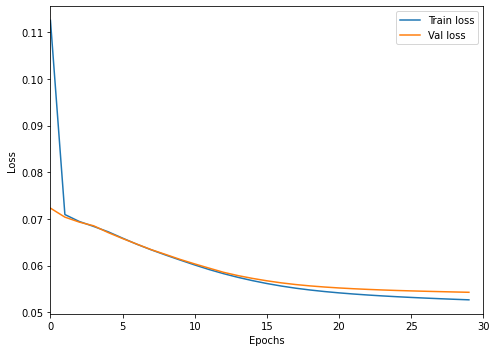

In [15]:
plt.figure(figsize=(7,5))
plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss');
plt.xlim(0, 30)
plt.legend()
plt.tight_layout()
plt.savefig('{}/loss.png'.format(weights_dir))